<a href="https://colab.research.google.com/github/dismaps/ODHeatMap/blob/main/ODHeatMap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ODHeatMap**: A Global Open Data District Heating Model (v1.1)
---
* Regarding the tool:
  * The objective of the tool is to *extract building footprints to calculate building surface area, and with that estimate buildings heat demand to assess District Heating feasibility.* **All of this using open data.**
  * The model is particularly useful when lacking data availability and accesibility.
  * It is set up as a 4 step workflow and the script allows for user flexibility and adaptability of the code.
  * All temporary outputs are saved in this notebook content directory: "/content/" and all geodata files are in GeoPackage format (.gpkg)
* For more information on the tool, visit the paper [in reviewing process]
* Help us improving the tool by sending comments via [email](<'diana@plan.aau.dk'>)
* Check out more about the [Sustainable Energy Planning and Management](https://www.en.aau.dk/education/master/urban-energy-and-environmental-planning/sustainable-energy-planning-management) group  at [AAU](https://www.en.aau.dk/)
<br>
<br>
---
* Overview of the tool's workflow:

> Step 1: Retrieving building foorprints as data input for the rest of the workflow.

> Step 2: Estimating the buildings envelope as surface area input.

> Step 3: Estimating the heating demand at a building level.

> Step 4: Estimating District Heating (DH) potential at an aggregated grid level.

<a id='sectionI'></a>
# **Step 1: Retrieve building footprints**

  * We choose one of the three methods for accessing building footprint open data.
<br>
  * Note: The coordinate reference system we manage in this step is "EPSG:4326", i.e. in global lat/lon format.
<br>

Input | Output
--- | ---
`Area of Interest (AOI)`  | `buildings.gpkg`

In [ ]:
# @title Import of libraries and environment
#Install libraries
!pip install pyrosm
!pip install mapclassify
import pyrosm
from pyrosm import OSM
from pyrosm import get_data
from pyrosm.data import sources
import warnings
warnings.filterwarnings('ignore')
import folium
import matplotlib
import mapclassify
#Clear installation output
from IPython.display import clear_output
clear_output()
print("Ok - All libraries installed and environment set up")

### a) Retrieve OSM building footprint

In [ ]:
# @title Area of Interest
# @markdown Choose the city to query from OSM { display-mode: "form" }

# @markdown ---
#The default area of interest is a city level due to RAM restrictions
city = "UlanBator" # @param ['Aachen','Aarhus','Adelaide','Albuquerque','Alexandria','Amsterdam','Antwerpen','Arnhem','Auckland','Augsburg','Austin','Baghdad','Baku','Balaton','Bamberg','Bangkok','Barcelona','Basel','Beijing','Beirut','Berkeley','Berlin','Bern','Bielefeld','Birmingham','Bochum','Bogota','Bombay','Bonn','Bordeaux','Boulder','BrandenburgHavel','Braunschweig','Bremen','Bremerhaven','Brisbane','Bristol','Brno','Bruegge','Bruessel','Budapest','BuenosAires','Cairo','Calgary','Cambridge','CambridgeMa','Canberra','CapeTown','Chemnitz','Chicago','ClermontFerrand','Colmar','Copenhagen','Cork','Corsica','Corvallis','Cottbus','Cracow','CraterLake','Curitiba','Cusco','Dallas','Darmstadt','Davis','DenHaag','Denver','Dessau','Dortmund','Dresden','Dublin','Duesseldorf','Duisburg','Edinburgh','Eindhoven','Emden','Erfurt','Erlangen','Eugene','Flensburg','FortCollins','Frankfurt','FrankfurtOder','Freiburg','Gdansk','Genf','Gent','Gera','Glasgow','Gliwice','Goerlitz','Goeteborg','Goettingen','Graz','Groningen','Halifax','Halle','Hamburg','Hamm','Hannover','Heilbronn','Helsinki','Hertogenbosch','Huntsville','Innsbruck','Istanbul','Jena','Jerusalem','Johannesburg','Kaiserslautern','Karlsruhe','Kassel','Katowice','Kaunas','Kiel','Kiew','Koblenz','Koeln','Konstanz','LaPaz','LaPlata','LakeGarda','Lausanne','Leeds','Leipzig','Lima','Linz','Lisbon','Liverpool','Ljubljana','Lodz','London','Luebeck','Luxemburg','Lyon','Maastricht','Madison','Madrid','Magdeburg','Mainz','Malmoe','Manchester','Mannheim','Marseille','Melbourne','Memphis','MexicoCity','Miami','Moenchengladbach','Montevideo','Montpellier','Montreal','Moscow','Muenchen','Muenster','NewDelhi','NewOrleans','NewYorkCity','Nuernberg','Oldenburg','Oranienburg','Orlando','Oslo','Osnabrueck','Ostrava','Ottawa','Paderborn','Palma','PaloAlto','Paris','Perth','Philadelphia','PhnomPenh','Portland','PortlandME','Porto','PortoAlegre','Potsdam','Poznan','Prag','Providence','Regensburg','Riga','RiodeJaneiro','Rostock','Rotterdam','Ruegen','Saarbruecken','Sacramento','Saigon','Salzburg','SanFrancisco','SanJose','SanktPetersburg','SantaBarbara','SantaCruz','Santiago','Sarajewo','Schwerin','Seattle','Seoul','Sheffield','Singapore','Sofia','Stockholm','Stockton','Strassburg','Stuttgart','Sucre','Sydney','Szczecin','Tallinn','Tehran','Tilburg','Tokyo','Toronto','Toulouse','Trondheim','Tucson','Turin','UlanBator','Ulm','Usedom','Utrecht','Vancouver','Victoria','WarenMueritz','Warsaw','WashingtonDC','Waterloo','Wien','Wroclaw','Wuerzburg','Wuppertal','Zagreb','Zuerich']
print('You selected', city)
# @markdown ---

In [ ]:
#Alternate geographical extents to replace string in the variable city.
#Note that regional/subregional query #demands stronger RAM capacity and
#data retrieval and parsing time.
#regions = list(pyrosm.data.available.get('regions'))
#subregions = list(pyrosm.data.available.get('subregions'))
#print(regions, subregions)

In [ ]:
#Parses OSM to readable object in GeoDataframe
fp = get_data(city)
# Initialize the OSM parser object
osm = OSM(fp)
#landuse = osm.get_landuse()
buildings = osm.get_buildings()
print(buildings.plot())

In [ ]:
#Geodataframe properties
buildings.shape

In [ ]:
#Saves the resulting footprints to file
buildings = buildings.to_crs('EPSG:4326')
buildings.to_file(filename = "buildings.gpkg", driver="GPKG")
print("")

### b) Retrieve ML generated building footprint

Data mining section adapted from [source](#https://github.com/microsoft/GlobalMLBuildingFootprints)

In [ ]:
# @title Import of libraries
#Install libraries
!pip install mercantile
import pandas as pd
import geopandas as gpd
import shapely.geometry
import mercantile
from tqdm import tqdm
import os
import tempfile
#Clear installation output
from IPython.display import clear_output
clear_output()
print("Ok - All libraries installed")

In [ ]:
#Define an Area of Interest (AOI)
# Geometry copied from https://geojson.io
aoi_geom = {
    "coordinates": [
        [
            [
              106.3969886266234,
              48.264980147822115
            ],
            [
              106.3969886266234,
              47.64132996214374
            ],
            [
              107.68262662240357,
              47.64132996214374
            ],
            [
              107.68262662240357,
              48.264980147822115
            ],
            [
              106.3969886266234,
              48.264980147822115
            ]
        ]
    ],
    "type": "Polygon",
}
aoi_shape = shapely.geometry.shape(aoi_geom)
minx, miny, maxx, maxy = aoi_shape.bounds

In [ ]:
#Determine which tiles of data intersect the AOI
quad_keys = set()
for tile in list(mercantile.tiles(minx, miny, maxx, maxy, zooms=9)):
    quad_keys.add(int(mercantile.quadkey(tile)))
quad_keys = list(quad_keys)
print(f"The input area spans {len(quad_keys)} tiles: {quad_keys}")

In [ ]:
#Reads the data and download the cropped results
df = pd.read_csv(
    "https://minedbuildings.blob.core.windows.net/global-buildings/dataset-links.csv"
)

idx = 0
combined_gdf = gpd.GeoDataFrame()
with tempfile.TemporaryDirectory() as tmpdir:
    # Download the GeoJSON files for each tile that intersects the input geometry
    tmp_fns = []
    for quad_key in tqdm(quad_keys):
        rows = df[df["QuadKey"] == quad_key]
        if rows.shape[0] == 1:
            url = rows.iloc[0]["Url"]

            df2 = pd.read_json(url, lines=True)
            df2["geometry"] = df2["geometry"].apply(shapely.geometry.shape)

            gdf = gpd.GeoDataFrame(df2, crs=4326)
            fn = os.path.join(tmpdir, f"{quad_key}.geojson")
            tmp_fns.append(fn)
            if not os.path.exists(fn):
                gdf.to_file(fn, driver="GeoJSON")
        elif rows.shape[0] > 1:
            raise ValueError(f"Multiple rows found for QuadKey: {quad_key}")
        else:
            raise ValueError(f"QuadKey not found in dataset: {quad_key}")

    # Merge the GeoJSON files into a single file
    for fn in tmp_fns:
        gdf = gpd.read_file(fn)  # Read each file into a GeoDataFrame
        gdf = gdf[gdf.geometry.within(aoi_shape)]  # Filter geometries within the AOI
        gdf['id'] = range(idx, idx + len(gdf))  # Update 'id' based on idx
        idx += len(gdf)
        combined_gdf = pd.concat([combined_gdf,gdf],ignore_index=True)

In [ ]:
#Saves the resulting footprints to file
print(combined_gdf.plot())
combined_gdf = combined_gdf.to_crs('EPSG:4326')
combined_gdf.to_file(filename = "buildings.gpkg", driver="GPKG")

### c) Upload building footprint file

In [ ]:
# @title ## Upload the file directly in the files pane or via mounting your drive
# @markdown Copy the file path from the drive.

# @markdown ---
# @markdown ### Enter a file path:
file_path = "/content/buildings.gpkg" # @param {type:"string"}
# @markdown ---

In [ ]:
#Mounting drive
#from google.colab import drive
#drive.mount("/drive")

#read file
buildings = gpd.read_file(file_path)

<a id='sectionI'></a>
# **Step 2: Estimate the buildings envelope**

  * We download the ANBH raster from [GHSL](https://human-settlement.emergency.copernicus.eu/download.php?ds=builtH) and upload it.
  * We set the coordinate reference system by defining an [EPSG code](https://epsg.io/) format.
<br>

Input | Output
--- | ---
`Coordinate reference system (CRS)`  | `built.gpkg`
`buildings.gpkg`  |
`ANHB.tif`  |

In [ ]:
# @title Import of libraries and environment
#Install libraries
!pip install rasterio
!pip install rasterstats
!pip install ipython-autotime
%load_ext autotime
import rasterstats
from rasterstats import zonal_stats
import pandas as pd
from osgeo import gdal
gdal.UseExceptions()
import matplotlib.pyplot as plt
import numpy as np
from rasterio.plot import show
from rasterio.plot import show_hist
import rasterio
from shapely.geometry import box

!pip install --upgrade geopandas
import geopandas as gpd

#Downloads
#fixes gdown issue if drive is mounted
!pip install --upgrade --no-cache-dir gdown
#!gdown #(file link) #file from drive

#Sets up paths
buildings_path = r"/content/buildings.gpkg"
ANBH_path = r"/content/ANBH.tif"

#Loads the files
buildings = gpd.read_file(buildings_path, driver='GPKG')
ANBH_raster = gdal.Open(ANBH_path)

#Clear installation output
from IPython.display import clear_output
clear_output()
print("Ok - All libraries installed and environment set up")

In [ ]:
# @title Define Coordinate Reference System
#EPSG code copied from https://epsg.io/ or https://spatialreference.org/

crs = 'EPSG:32648' # @param {type:"string"}

### Step 2.1. Aligns and clips ANBH raster to building bounding box

In [ ]:
#Reprojects buildings dataset
buildings = buildings.to_crs(crs=crs)

#Creates AOI gdf from buildings bounding box
aoi_geom = box(*buildings.total_bounds)
aoi = gpd.GeoDataFrame({'id': [1]}, geometry=[aoi_geom])
aoi.to_file('/content/aoi.gpkg', driver='GPKG', crs=crs)

In [ ]:
#Cuts and reprojects native ANBH raster to buildings bounding box
ANBH_clip = gdal.Warp("/content/ANBH_clip.tif", ANBH_raster, cutlineDSName = "/content/aoi.gpkg", cropToCutline = True, dstNodata = np.nan, dstSRS= crs)
array = ANBH_clip.GetRasterBand(1).ReadAsArray()

In [ ]:
#Plots buildings, ANBH raster data histogram
masked_array = np.ma.masked_where((array == 0) | np.isnan(array), array)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize= (18,6))

#Plot the raster data with colorbar
im1 = ax1.imshow(masked_array, cmap='plasma', alpha=0.6)
cbar = fig.colorbar(im1, ax=ax1, label='Average Height in 100x100m res (m)', shrink=0.5, orientation='horizontal')
ax1.set_title('Clipped ANBH raster dataset in AOI')

#Plot histogram
show_hist(masked_array, title = "Histogram", ax = ax2, lw=0.0,  alpha=0.3, stacked = False, bins=50, label = "Average Building Net Height [m]")

fig.tight_layout()
plt.show()
rf = None

### Step 2.2. Performs zonal statistics and joins raster data to buildings

In [ ]:
#Defines function for perform zonal statistics
def get_zonal_statistics (vector, raster, stats):
  #Stats can be ['count', 'min', 'max', 'mean', 'sum', 'std', 'median', 'majority', 'minority', 'unique', 'range', 'nodata', 'nan']
  zonal_results = rasterstats.gen_zonal_stats(
        vector,
        raster,
        all_touched=True,
        band=1,
        categorical=False,
        nodata=0,
        stats = stats,
        geojson_out=True)

  geostats = gpd.GeoDataFrame.from_features(zonal_results)
  not_identified = geostats[stats].isna().sum()
  print(f"Na data: {not_identified} is na, out of {len(geostats)}")
  return geostats

#Defines function for droppin non identified buildings
def drop_not_identified(df, columns):
  not_identified = df[columns].isna().sum()
  df1 = df.dropna(subset = columns)
  print(f"{not_identified} features dropped in {columns}")
  return df1

In [ ]:
#The average performance rate of this function is 200 buildings per second
#Performs zonas statistics
buildings_stats = get_zonal_statistics(buildings, 'ANBH_clip.tif', stats = ['median']).set_crs(crs = crs)
#Drops non identified buildings
buildings_stats = drop_not_identified(buildings_stats, columns=['median'])

### Step 2.3. Calculates building parameters calculations

In [ ]:
builtg = buildings_stats.copy()
#Calculates area and perimeter of polygons
builtg["height_e"] = builtg['median']
builtg["area_c"] = builtg.area
builtg["perimeter_c"] = builtg.length
builtg["surface_c"] = (2*builtg["area_c"])+(builtg["height_e"]*builtg["perimeter_c"])

In [ ]:
built = gpd.GeoDataFrame(builtg.iloc[:,-8:], geometry=builtg.geometry, crs=builtg.crs)

### Step 2.4. Filters irrelevant geographical features (optional)

This section is designed for the case of Mongolia where ger tents need to be identified within the building dataset. It serves as an example on how geographical feature filtering can be set-up, it includes:
* Ger tents identification through circle geometry as a proxy, this is:
$$ If > (P^2/(4*A) ≈ 3.14 (3.14 < x < 3.33) $$
* Filter out of buildings identified as ger tents falling out of the standard ger size. This is the condition: built ["ger"] == "ger"  built["area_c"] > 100
* Filter out of geometric features that exhibited irrelevant or unrealistic characteristics for building types i.e., statues, planes, boxes, cars, etc. This is specially important if ML footprints are used. The condition is: built["area_c"] <= 15

In [ ]:
#Identifies ger tents through geometry
built["if_ger"] = (built["perimeter_c"]**2)/(4*built["area_c"])
built["ger"] = built["if_ger"].apply(lambda x: "ger" if 3.14 < x < 3.33 else np.nan)

def categorize_gers (row, height):
  if row["ger"] == "ger":
    return height
  else:
    return round(row["height_e"],2)

def filter_out_conditions(conditions, df):
  o = len(df)
  for i in conditions:
    a = len(df.query(i).index)
    if a:
      df = df.drop(df.query(i).index)
      print(f"From  {o}; {a} features where deleted from {i}. Total features: {len(df)}")
    else:
      print(f"From  {o}; 0 features where deleted from {i}")
      None
  return df.head()

#Sets ger height to 2.5m
built["height_c"] = built.apply(lambda row: categorize_gers (row, 2.5), axis=1)

#Sets filtering conditions
conditions= ["ger == ger & area_c > 100", "area_c <= 15"]
filter_out_conditions(conditions, built)

### Step 2.5. Saves file

In [ ]:
built.to_file('built.gpkg', driver='GPKG', crs=crs)

<a id='sectionI'></a>
# **Step 3: Estimate the buildings heat demand**

  * We connect to the Copernicus Climate Data Store (CDS) using the [API](https://cds.climate.copernicus.eu/api-how-to) and set the user {url} and {key} in the *Import of libraries and environment* cell.
  * We calculate the daily Heating and Cooling Degree Days (HDD and CDD) setting a reference temperature.
  * We calculate the heating demand seting a heat loss U-value, and a domestic hot water (DHW) demand share.
<br>

Input | Output
--- | ---
`built.gpkg`  |`HDD_CDD.csv`
`Copernicus CDS API key and client`|`built_hd.gpkg`

In [ ]:
# @title Import of libraries and environment
#Install libraries
!pip install atlite
!pip install mapclassify
!pip install importlib-metadata==4.13.0
!pip install ipython-autotime
#!pip install tabulate
%load_ext autotime
from IPython.display import clear_output

#User input to fill in url and key for CDS API access
#Copernicus climate data setup (API key and client)
url = 'insert url'
key = 'insert key'

with open('/root/.cdsapirc', 'w') as f:
    f.write('\n'.join([url, key]))

with open('/root/.cdsapirc') as f:
    print(f.read())
!pip install cdsapi

#Imports
import atlite
import logging
logging.basicConfig(level=logging.INFO)
import geopandas as gpd
import matplotlib.pyplot as plt
import mapclassify
import cdsapi
import numpy as np
import pandas as pd
from tabulate import tabulate
import warnings
warnings.filterwarnings('ignore')
import folium
clear_output()

#Downloads
#fixes gdown issue if drive is mounted
!pip install --upgrade --no-cache-dir gdown
#!gdown #(file link) #file from drive

built_path = r"/content/built.gpkg"
built = gpd.read_file(built_path, layer='built')

#Clear installation output
from IPython.display import clear_output
clear_output()
print("Ok - All libraries installed and environment set up")

In [ ]:
#@title Functions definition

#Function that assures the minimum width d=0.25 degrees of the slide for atlite cutout
def check_bounds_x_y(df, d):
  bounds = df.to_crs("EPSG:4326").total_bounds
  print(f"The boundary is {bounds} before enlargement")
  bounds_e = bounds.copy()
  if bounds[0] + d > bounds[2]:
    bounds_e[0] = bounds[0] - d
    bounds_e[2] = bounds[2] + d
    print("Enlargement in X performed")
    if bounds[1] + d > bounds[3]:
      bounds_e[1] = bounds[1] - d
      bounds_e[3] = bounds[3] + d
      print("Enlargement in Y performed")
      print(f"The boundary is {bounds_e} after enlargement")
      return bounds_e
  else:
    print("No enlargement of boundary performed")
    return bounds

#Plots min, mean, max temperature in the year
def hourly_temperature_plot (x,ref_temp):
  from matplotlib.dates import MonthLocator, DateFormatter
  fig = plt.figure(figsize=(20, 7))
  ax = fig.add_subplot()
  (x.temperature - 273.15).max(['x', 'y']).plot(label='Max', color='mediumseagreen',linewidth = 0.5)
  (x.temperature - 273.15).min(['x', 'y']).plot(label='Min', color='coral',linewidth = 0.5)
  (x.temperature - 273.15).mean(['x', 'y']).plot(label='Mean', color='cadetblue', linestyle ='dashed',linewidth = 0.5)

  ax.xaxis.grid(True)
  ax.xaxis.set_major_locator(MonthLocator())  # Tick locator
  ax.xaxis.set_major_formatter(DateFormatter('%b'))  # Date format
  _ = plt.xticks(rotation=0)
  plt.axhline(y = ref_temp, color='gray', linestyle ='dashed', linewidth = 1, label=f'{ref_temp}°C')

  ax.set_frame_on(True)
  ax.xaxis.set_visible(True)
  plt.minorticks_off()
  ax.set_title("Yearly hourly outdoor temperature")
  ax.legend()
  return plt.show()

#Calculates HDD and CDD related to the reference temperature set throughout the year and throughtout heating season (if given)
def calculates_HCDD(x, ref_temp, start_heating_month="01", end_heating_month="12"):# start_date=df.index.min(), end_date=df.index.max()):
  #Defines cutout and creates df with average daily temperatures
  df1 = x.temperature.mean(['x', 'y']).to_dataframe()
  df1['DATE'] = pd.to_datetime(df1.index, format='%Y-%m-%d')
  df = df1.groupby(pd.Grouper(freq='d', key='DATE')).mean()

  #Performs calculations
  df['temperature'] = df['temperature'] - 273.15 #to C
  df['t_dif'] =  ref_temp - df['temperature']
  df['HDD'] = df['t_dif'].apply(lambda x: x if x > 0 else np.nan)
  df['CDD'] = df['t_dif'].apply(lambda x: x if x < 0 else np.nan)
  HDD = round(df.HDD.sum(),2)
  CDD = round(df.CDD.sum()*-1,2)
  print(f"HDD = {HDD} and CDD = {CDD} for {len(df)} days when the temperature of reference is {ref_temp}°C")

  #If heating season is given
  filtering_dates = (df.index.strftime('%m') <= end_heating_month) + (df.index.strftime('%m') >= start_heating_month)
  df1 = df[filtering_dates]
  HDD_HS = round(df1.HDD.sum(),2)
  print(f"HDD_HS = {HDD_HS} for {len(df1)} days of heating season  when the temperature of reference is {ref_temp}°C")
  return df, ref_temp, HDD, CDD, HDD_HS

def HCDD_plot (df, ref_temp, HDD, CDD, year):
  from matplotlib.dates import MonthLocator, DateFormatter
  fig = plt.figure(figsize=(20, 7))
  ax = fig.add_subplot()

  df.HDD.plot.bar(label='HDD', color='mediumseagreen')
  df.CDD.plot.bar(label='CDD', color='coral')
  plt.axhline(y = 0, color='gray', linestyle ='dashed', linewidth = 0.5, label=f'Ref Temp is {ref_temp}°C')

  ax.xaxis.grid(True)
  ax.xaxis.set_major_locator(MonthLocator())  # Tick locator
  ax.xaxis.set_major_formatter(DateFormatter('%b'))  # Date format
  _ = plt.xticks(rotation=0)

  #Format
  plt.minorticks_off()
  ax.legend()
  ax.set_title(f"HDD and CDD when reference temperature is {ref_temp}°C \n [HDD = {HDD}, CDD = {CDD}, year = {year}]")
  return plt.show()

#Clear installation output
from IPython.display import clear_output
clear_output()
print("All functions needed for this script are defined")

### Step 3.1. Retrieves climate data using the Climate Data Store (CDS) Application Program Interface [API](https://cds.climate.copernicus.eu/api-how-to)

In [ ]:
#Fixes geographical bounds in case bounds do not make it to the cutout d=0.25 for ERA5
bounds = check_bounds_x_y(built, 0.25) # total_bounds returns a tuple with x, y, X, Y

In [ ]:
# @title Slice of time for ERA5 hourly dataset
# @markdown Choose the year of analysis { display-mode: "form" }

# @markdown ---
import calendar
year = 2019 # @param {type:"slider", min:2010, max:2020, step:1}
date_in = str(year)+"-01-01"
date_out = str(year)+"-12-31"

print(f"The date range is from {date_in} to {date_out}")

In [ ]:
#Prepares the cutout slices in "EPSG:4326"
cutout = atlite.Cutout(path=f"2019-hourly-era5.nc",
                       module="era5",
                       x=slice(bounds[0], bounds[2]),
                       y=slice(bounds[1], bounds[3]),
                       time= slice(date_in,date_out) #slice format ("2011-01-05", "2011-01-25")
                       )

In [ ]:
cutout.prepare()

In [ ]:
#Saves array to content
import xarray as xr
x = cutout.data
x.to_netcdf('/content/1/2019-hourly-era5.nc')

#Open array
#x = xr.open_dataset('/content/2019-hourly-era5.nc')

### Step 3.2. Calculates daily heating and cooling degree days (HDD and CDD)

The formulas used in this section are the following:

$$DD = \sum_{i=1}^{n=365} \Delta T^i$$
$${\Delta T_{HDD}}^i = {{T_{ref}} - {T_{ave}}} \text { for } {T_{ave} \leq {T_{ref}}}$$
$${\Delta T_{CDD}}^i = {{T_{ave}} - {T_{ref}}} \text { for } {T_{ave} > {T_{ref}}}$$

In [ ]:
# @title Set up reference temperature
# @markdown Choose reference temperature for HDD and CDD analysis in °C { display-mode: "form" }

# @markdown ---
import calendar
ref_temp = 20 # @param {type:"slider", min:10, max:25, step:1}

print(f"The reference temperature for HDD and CDD calculations is {ref_temp}°C")

In [ ]:
#Plots hourly temperature
hourly_temperature_plot(x,ref_temp)

In [ ]:
#Calculates HDD and CDD
df, ref_temp, HDD, CDD, HDD_HS = calculates_HCDD(x, ref_temp, start_heating_month="10", end_heating_month="05")

In [ ]:
#Plots results
HCDD_plot (df, ref_temp, HDD, CDD, year)

In [ ]:
#Export HDD and CDD calculations as csv
df.to_csv('/content/HDD_CDD.csv')

### Step 3.3. Calculates heating demand at building level

The formulas used in this section are the following:

$$hd = \text{Building surface}*U-value*HDD$$

In [ ]:
# @title Heat loss coeficient U-value estimation
# @markdown Select the u-value { display-mode: "form" }

# @markdown ---
u_value = 0.6 # @param {type:"slider", min:0.1, max:5, step:0.1}

print(f"The U-value input is {u_value}")

In [ ]:
# @title Domestic hot water demand (DHW)
# @markdown Select the DHW demand as a share of the heat demand { display-mode: "form" }

# @markdown ---
dhw_share = 0.25 # @param ["0.10", "0.15", "0.20", "0.25", "0.30", "0.35", "0.40", "0.45", "0.50", "0.55", "0.60", "0.65", "0.70", "0.75", "0.80", "0.85", "0.90", "0.95", "1.0"] {type:"raw"}

print(f"The DHW share is {dhw_share} of the heat demand")

In [ ]:
#Calculates heat demand per building
built['heat_demand_MWh'] = (built.surface_c)*u_value*HDD_HS*24/(1e6) #24h in a day
built['dhw_MWh'] = built['heat_demand_MWh']*dhw_share
built['n_floors'] = round(built.height_c/2.5,0)#assumes 2.5m floor height
built['floor_area'] = built['n_floors']*built.area_c
built['kWh/m2']= 1000*(built.heat_demand_MWh+built.dhw_MWh)/(built.floor_area)
built.head(3)

In [ ]:
#Prints summary of calculations
built[["heat_demand_MWh","dhw_MWh","n_floors","floor_area","kWh/m2"]].describe()

In [ ]:
#Prints statistics of built
#selects columns
selected_columns = ["heat_demand_MWh", "dhw_MWh", "n_floors", "floor_area", "kWh/m2"]
#Calculate count, mean, and sum for selected columns
summary_table = built[selected_columns].agg(['count', 'mean', 'sum']).astype(int)
# Rename the index for better readability
summary_table.rename(index={'count': 'Count', 'mean': 'Mean', 'sum': 'Sum'}, inplace=True)
# Specify format for floating-point numbers
summary_str = tabulate(summary_table, headers='keys', tablefmt='grid', floatfmt=",.2f")
# Print the pretty table
print(summary_str)

In [ ]:
#Plot map with categorized building heat demands
built.plot(column='kWh/m2', legend=True, scheme="quantiles", figsize=(15, 10))

### Step 3.4. Export interactive plot as an html file (optional)

In [ ]:
#Export interactive plot as an html file (opcional)
built_map = built.copy()

# Create a map centered at a specific location
m = folium.Map(location=[built_map.total_bounds[1], built_map.total_bounds[0]], zoom_start=10)

# Change the basemap layer using a different tileset
folium.TileLayer("Cartodb Positron").add_to(m)  # You can use different tilesets like 'OpenStreetMap', 'Mapbox Bright', 'Stamen Terrain', etc.

# Simplify geometries
built_map['geometry'] = built_map['geometry'].simplify(tolerance=0.0005)

# Add GeoDataFrame as a GeoJSON layer to the map
folium.GeoJson(
    built_map,
    name='choropleth',
    style_function=lambda x: {'fillColor': '2a9d8f', 'color': '2a9d8f', 'weight': 1},
    tooltip=folium.GeoJsonTooltip(fields=['kWh/m2'], labels=True, sticky=False)
).add_to(m)

# Add a legend
folium.LayerControl().add_to(m)

outfp = r"/content/built.html"
total_bounds_list = built_map.total_bounds.tolist()
m.fit_bounds(total_bounds_list)
m.save(outfp)

### Step 3.5. Saves output

In [ ]:
built.to_file('/content/built_hd.gpkg', driver='GPKG')

<a id='sectionI'></a>
# **Step 4: Estimate district heating feasibility**

  * We aggregate the heat demands on a user defined grid size.
  * We filter the grid area of interest (opcional).
  * We calculate DH feasibility via heat density or cost estimates.
<br>

Input | Output
--- | ---
`built_hd.gpkg`  |`DH_grid.gpkg`

In [ ]:
# @title Import of libraries and environment
#Install libraries
!pip install ipython-autotime
!pip install mapclassify
%load_ext autotime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from shapely import geometry
import seaborn as sns
import folium
import geopandas as gpd

#Downloads
#fixes gdown issue if drive is mounted
!pip install --upgrade --no-cache-dir gdown
#!gdown #(file link) #file from drive

built_hd_path = r"/content/built_hd.gpkg"
built_hd = gpd.read_file(built_hd_path)

#Clear installation output
from IPython.display import clear_output
clear_output()
print("Ok - All libraries installed and environment set up")

In [ ]:
#@title Functions definition
def create_fishnet(gdf, size, plot=True):
  #gets parameters from gdf
  total_bounds = gdf.total_bounds
  minX, minY, maxX, maxY = total_bounds
  crs= gdf.crs
  #create a fishnet
  x, y = (minX, minY)
  geom_array = []
  # Polygon Size
  square_size = size

  while y <= maxY:
      while x <= maxX:
          geom = geometry.Polygon([(x,y), (x, y+square_size), (x+square_size, y+square_size), (x+square_size, y), (x, y)])
          geom_array.append(geom)
          x += square_size
      x = minX
      y += square_size
  fishnet = gpd.GeoDataFrame(geom_array, columns=['geometry']).set_crs(crs)
  print(f"Fishnet created. Size: {len(fishnet)} pixels of {fishnet.area.unique()} m2.")

  if plot is True:
    fig, ax = plt.subplots(figsize=(15, 15))
    fishnet.plot(ax=ax, facecolor="none",edgecolor='lightgrey')
    gdf.plot(ax=ax, color="mediumaquamarine", alpha=0.8)
    #ax.set_ylim(5.306e6,5.310e6) (for zoom in)
    #ax.set_xlim(640000,645000) (for zoom in)
    name =[x for x in globals() if globals()[x] is gdf][0]
    ax.set_title(f"n={len(fishnet)}, size={size}x{size}m, area={fishnet.area.unique()} m2{chr(10)}Using df={name}", color='grey')
  else:
    pass

  return fishnet

def create_density_grid(polygons, grid, column, plot=True):
  #Creates centroids from building polygons
  polygons_centroids = polygons[['sh_MWh', 'dhw_MWh','heat_demand_MWh', 'kWh/m2', 'geometry']].copy() #choose columns
  polygons_centroids['geometry'] = polygons_centroids['geometry'].centroid

  #merges centroids into grid
  merged = gpd.sjoin(polygons_centroids, grid, how='left', predicate='within')
  grouped = merged.groupby('index_right').agg({'heat_demand_MWh': 'sum'})
  grouped = grouped.reset_index()
  grouped = grouped.merge(grid.geometry, left_on='index_right', right_index=True)
  net = gpd.GeoDataFrame(grouped, geometry='geometry')
  net.crs = grid.crs

  if plot:
    #Plots
    fig, ax = plt.subplots(figsize= (18,6))
    net.plot(ax=ax, column=column, edgecolor="none",cmap='magma_r', legend=True, alpha=0.8)#, legend_kwds={"orientation": "horizontal", "pad": 0.01})
    ax.set_title(f"Aggregated {column} in a {int(grid.area[0])**(1/2)}x{int(grid.area[0])**(1/2)}m ({int(grid.area[0])}m\u00B2) grid")
  else:
    pass

  return net

### Step 4.1. Aggregates heat demand in grid

In [ ]:
test = built_hd.copy()
test['heat_demand_MWh'] = test['heat_demand_MWh'] + test['dhw_MWh']

time: 221 ms (started: 2024-04-15 11:16:51 +00:00)


In [ ]:
# @title Input grid size for the aggregation
# @markdown Choose the grid size in meters { display-mode: "form" }

# @markdown ---
grid_size = 500 # @param ["100", "250", "500", "1000"] {type:"raw"}

print(f"The grid size is set to {grid_size}x{grid_size}m")

The grid size is set to 500x500m
time: 1.69 ms (started: 2024-04-15 11:16:51 +00:00)


Fishnet created. Size: 39552 pixels of [250000.] m2.


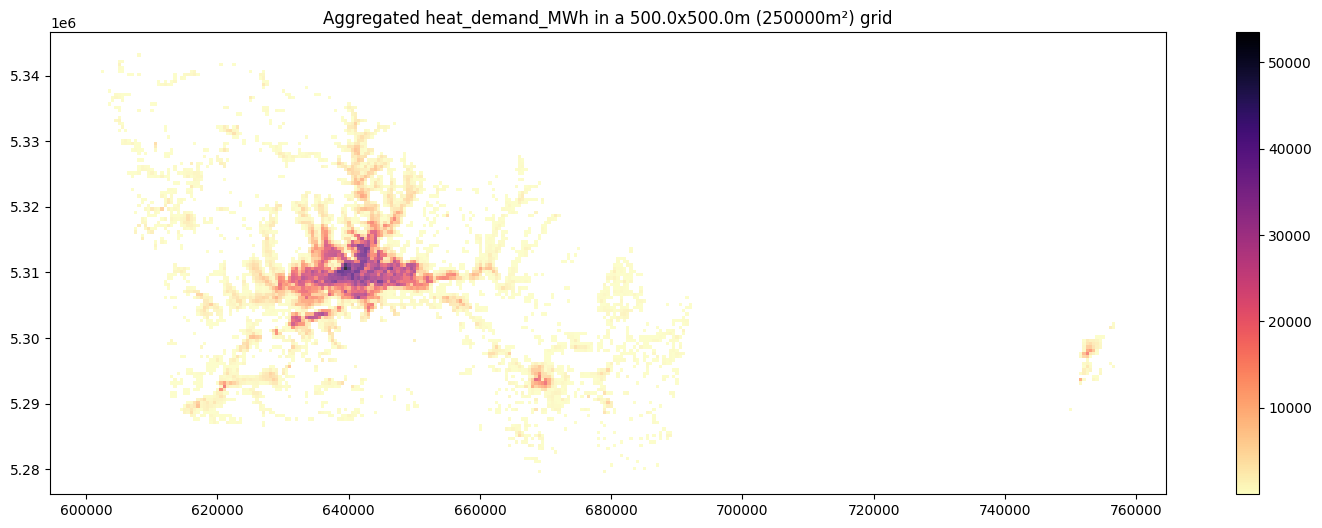

time: 10.7 s (started: 2024-04-15 11:16:51 +00:00)


In [ ]:
#Creates the grid
DH_grid = create_density_grid(test,
                        grid = create_fishnet(test, size = grid_size, plot=False),
                        column = "heat_demand_MWh",
                        plot=True)

In [ ]:
#calculates density and identifies size grid
DH_grid['heat_density'] = round(DH_grid['heat_demand_MWh']*1000 / (DH_grid.area[0]),2) #kWh/m2
#DH_grid['heat_density_ee'] = round(DH_grid['total_MWh_ee']*1000 / (DH_grid.area[0]),2)
DH_grid['id'] = f"grid_{str(int(DH_grid.area[0]**(1/2)))}m"
DH_grid

,index_right,heat_demand_MWh,geometry,heat_density,id
0,133,274.076096,"POLYGON ((668777.953 5279402.221, 668777.953 5...",1.10,grid_500m
1,153,298.460832,"POLYGON ((678777.953 5279402.221, 678777.953 5...",1.19,grid_500m
2,471,24.107654,"POLYGON ((683277.953 5279902.221, 683277.953 5...",0.10,grid_500m
3,474,12.853226,"POLYGON ((684777.953 5279902.221, 684777.953 5...",0.05,grid_500m
4,773,143.526664,"POLYGON ((679777.953 5280402.221, 679777.953 5...",0.57,grid_500m
...,...,...,...,...,...
4537,38352,234.189851,"POLYGON ((620277.953 5341402.221, 620277.953 5...",0.94,grid_500m
4538,38356,112.147046,"POLYGON ((622277.953 5341402.221, 622277.953 5...",0.45,grid_500m
4539,38630,229.807131,"POLYGON ((604777.953 5341902.221, 604777.953 5...",0.92,grid_500m
4540,38631,214.273925,"POLYGON ((605277.953 5341902.221, 605277.953 5...",0.86,grid_500m


time: 186 ms (started: 2024-04-15 11:17:02 +00:00)


### Step 4.2. Filters grid (optional)

####a) Creates spatial clustered heat densities

In [ ]:
test = DH_grid.copy()

time: 8.19 ms (started: 2024-04-15 10:57:21 +00:00)


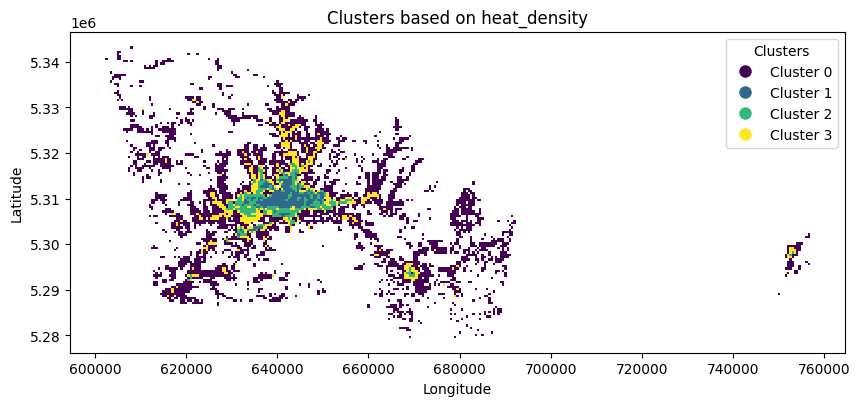

time: 1.46 s (started: 2024-04-13 17:53:31 +00:00)


In [ ]:
#Creates clusters from gdf based on column values
def create_clusters(gdf,column= 'heat_density', n_clusters=4, cmap='viridis'):
  from sklearn.cluster import KMeans
  from sklearn.preprocessing import StandardScaler
  from matplotlib.colors import ListedColormap

  clustered_gdf = gdf.copy()

  # Prepare data
  X = clustered_gdf[[column]]

  # Standardize features
  scaler = StandardScaler()
  X_scaled = scaler.fit_transform(X)

  # Apply K-means clustering
  kmeans = KMeans(n_clusters=n_clusters)
  clusters = kmeans.fit_predict(X_scaled)

  # Assign cluster labels to polygons
  clustered_gdf['cluster_label'] = clusters

  # Create a colormap from the random colors
  #cmap = ListedColormap(np.random.rand(len(clustered_gdf['cluster_label'].unique()), 3))
  # Get the specified colormap
  cmap = plt.cm.get_cmap(cmap, n_clusters)

  # Visualize clusters
  fig, ax = plt.subplots(figsize=(10, 10))
  ax.set_aspect('equal')  # Ensure aspect ratio is equal
  clustered_gdf.plot(column='cluster_label', cmap=cmap, legend=False, ax=ax, edgecolor= None, linewidth=0.5)
  ax.set_xlabel('Longitude')
  ax.set_ylabel('Latitude')
  ax.set_title('Clusters based on ' + column)

  # Create custom legend
  legend_labels = [f'Cluster {i}' for i in range(n_clusters)]
  legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markersize=10, markerfacecolor=cmap(i)) for i in range(n_clusters)]
  ax.legend(legend_handles, legend_labels, loc='upper right', title='Clusters', fontsize='medium')

  return clustered_gdf

clustered_DH_grid = create_clusters(test,column= 'heat_density', n_clusters=4)

<Axes: >

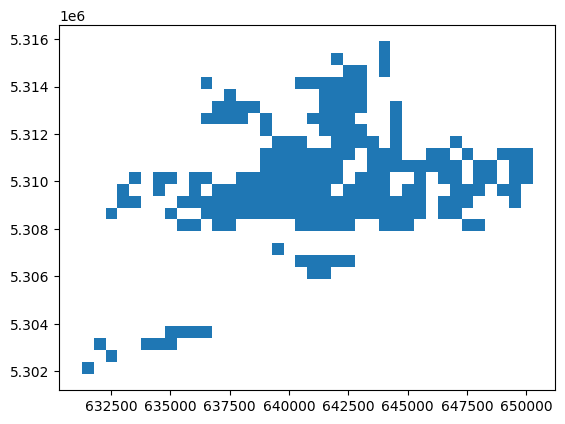

time: 297 ms (started: 2024-04-13 17:56:34 +00:00)


In [ ]:
#Plots the grid by cluster number, select the number according to map
clustered_DH_grid[clustered_DH_grid['cluster_label'] == 1].plot() #AND test[(test['cluster_label'] == 1) | (test['cluster_label'] == 2)]

In [ ]:
#Redefines grid, filtering out part of the total grid
DH_grid = clustered_DH_grid[clustered_DH_grid['cluster_label'] == 1].copy()

####b) Defines distance from grid centroid

In [ ]:
test = DH_grid.copy()

time: 3.5 ms (started: 2024-04-13 17:58:42 +00:00)


In [ ]:
# @title Define threshold distance
# @markdown Input the buffer distance for DH estimation in kilometers { display-mode: "form" }

# @markdown ---
threshold_distance = 15 # @param {type:"integer"}

print(f"The threshold distance is {threshold_distance}km")

The threshold distance is 15km
time: 6.83 ms (started: 2024-04-13 18:19:46 +00:00)


In [ ]:
def set_distance_threshold(gdf, threshold_distance, use_max_density_centroid= True):
  #Slices grid by distance of centroids
  from shapely.geometry import Point

  if use_max_density_centroid:
    centroid_ref = gdf.loc[gdf['heat_density'].idxmax()].geometry.centroid

  else:
    # Compute centroid of aggregated polygon area
    centroid_ref = test.unary_union.centroid

  # Compute distance from each polygon centroid to aggregated centroid
  gdf['centroid_distance'] = gdf.centroid.distance(centroid_ref)

  # Filter out polygons beyond the threshold distance
  filtered_grid = gdf[gdf['centroid_distance'] <= (threshold_distance*1000)]

  # Plot filtered polygons for visualization
  filtered_grid.plot()

  return filtered_grid

time: 1.06 ms (started: 2024-04-13 18:19:49 +00:00)


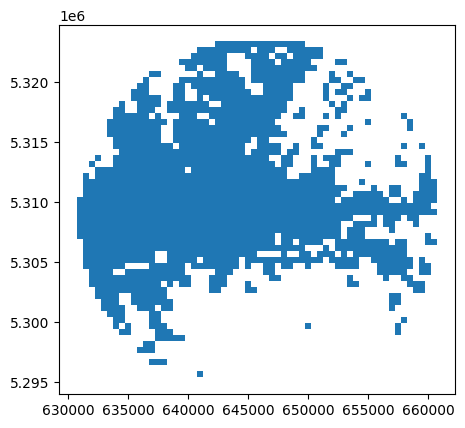

time: 1.11 s (started: 2024-04-13 18:19:50 +00:00)


In [ ]:
filtered_grid = set_distance_threshold(test, threshold_distance, use_max_density_centroid= False)

In [ ]:
#Redefines grid, filtering out part of the total grid
DH_grid = filtered_grid.copy()

####c) User uploaded areas

In [ ]:
test = DH_grid.copy()

time: 13.2 ms (started: 2024-04-15 11:17:02 +00:00)


In [ ]:
#asks for file, performs join and identification of area
areas_gdf = gpd.read_file(r"/content/ub_areas.gpkg")

time: 50.2 ms (started: 2024-04-15 11:17:02 +00:00)


In [ ]:
#spatial joins and characterizes the buildings under those areas
def spj_areas(gdf1,gdf2,outer="out"):
  if gdf1.crs == gdf2.crs:
    join = gdf1.drop(columns=['index_right']).sjoin(gdf2, how="left", predicate='within')
    join = join[~join.index.duplicated(keep='first')] #for it not to assign more than one category
    join = join.fillna(value={"area": outer }) #Caracterize the outer
    print(f"Summary of buildingds join: {chr(10)} {pd.value_counts(join['area'])} {chr(10)} NaN values are: {join['area'].isna().sum()} {chr(10)}")
    return join
  else:
    print("Databases CRS do not match")
    return None

classified_grid = spj_areas(test, areas_gdf)

Summary of buildingds join: 
 area
out    2313
ger    1960
chn     269
Name: count, dtype: int64 
 NaN values are: 0 

time: 242 ms (started: 2024-04-15 11:17:02 +00:00)


<Axes: >

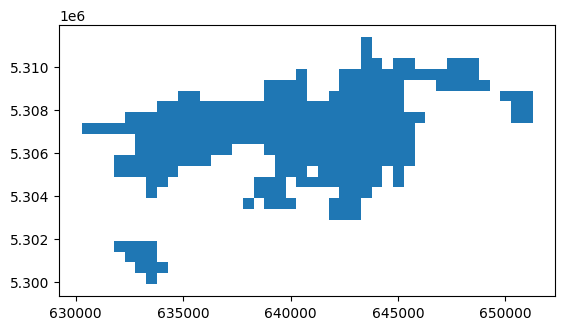

time: 1.01 s (started: 2024-04-15 11:17:02 +00:00)


In [ ]:
classified_grid[classified_grid['area'] == "chn"].plot()

In [ ]:
#Redefines grid, filtering out part of the total grid
DH_grid = classified_grid[classified_grid['area'] == "chn"].copy()

time: 19.9 ms (started: 2024-04-15 11:17:03 +00:00)


### Step 4.3. Calculates District Heating feasibility

#### a) District Heating feasibility via heat density class
From [(Persson, U., et al. 2019)](https://doi.org/10.1016/j.energy.2019.03.189). DH potential is within density classes 3-5.

| Heat density class | Heat density intervals [MJ/m2] | Concentration of heat demands     |
|--------------------|---------------------------------|-----------------------------------|
| 1                  | 0 < qL < 20                     | Very sparse                       |
| 2                  | 20 ≤ qL < 50                    | Sparse                            |
| **3**              | **50 ≤ qL < 120**               | **Moderate**                      |
| **4**              | **120 ≤ qL < 300**              | **Dense**                         |
| **5**              | **qL ≥ 300**                    | **Very dense**                    |


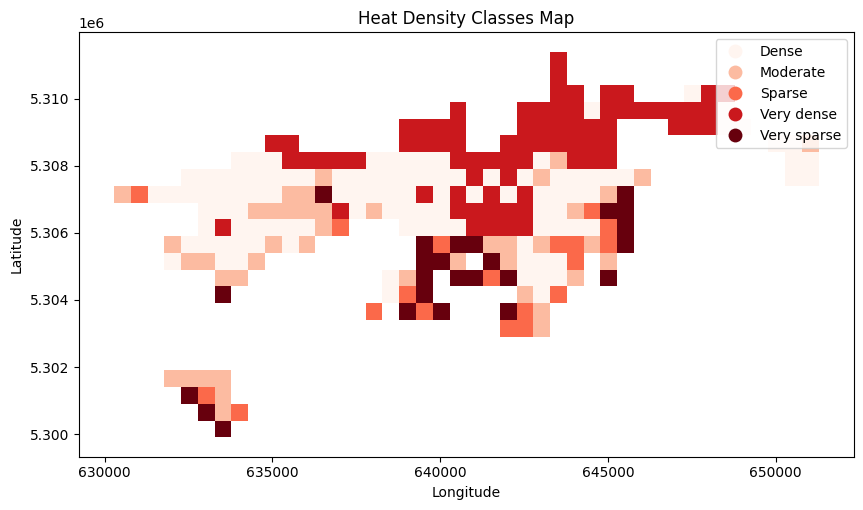

time: 721 ms (started: 2024-04-15 11:17:03 +00:00)


In [ ]:
# Define the bins and labels for categorization
bins = [-float('inf'), 6, 14, 33, 83, float('inf')] #bins are in kWh/m2
labels = ['Very sparse', 'Sparse', 'Moderate', 'Dense', 'Very dense']
# Apply categorization using pd.cut()
DH_grid['heat_density_class'] = pd.cut(DH_grid['heat_density'], bins=bins, labels=labels, right=False)
DH_grid['heat_density_class'] = DH_grid['heat_density_class'].astype(str)

# Plot the map
fig, ax = plt.subplots(figsize=(10, 10))
DH_grid.plot(column='heat_density_class', ax=ax, legend=True, cmap='Reds')

# Add title and labels
ax.set_title('Heat Density Classes Map')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Show the plot
plt.show()

In [ ]:
#sum of demand in mode-very dense area
#creates pivot and sums
pivot = pd.pivot_table(DH_grid,
                       index= ["area", "heat_density_class"],
                       values= ['heat_demand_MWh'],
                       aggfunc=["sum"],
                       margins=True, margins_name="Total",
                       fill_value=0
                       ).round(0).astype(int)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 2)
display(pivot)

sum      
                         heat_demand_MWh
area  heat_density_class                
chn   Dense                   1595883   
      Moderate                 251473   
      Sparse                    48984   
      Very dense              2121394   
      Very sparse               14476   
Total                         4032209

time: 51.8 ms (started: 2024-04-15 11:17:04 +00:00)


#### b) District Heating feasibility via cost estimates

The formula used for the total annualized investment cost is made following a regression analysis using the methodology from [(Möller, B., et al. 2018)](https://doi.org/10.1016/j.energy.2018.06.025)

$$ TAC =  [a*\text{Heat density}^{(-b)}]*annuity $$
and $$annuity = \frac{r}{1-(1+r)^{-n}}$$


In [ ]:
#This is an example for calculating DH cost estimations
#Defines variables
density = DH_grid['heat_density']
demand = DH_grid['heat_demand_MWh']

#Financial parameters
discount_rate = 0.0875
dh_pipe_years = 30
annualized = (discount_rate/(1-(1+discount_rate)**-dh_pipe_years))

#Calculates annualized costs with function from X (HRE)
DH_grid['MMNT_MWh'] = 7.8301*(density**(-0.549))*annualized

#Order demands from small to large
DH_grid.sort_values('MMNT_MWh', ascending=True, inplace=True)
DH_grid['HD_%'] = (demand / (demand.sum())*100)
DH_grid['HD_%_ACC'] = DH_grid['HD_%'].cumsum()

time: 14.8 ms (started: 2024-04-15 11:17:04 +00:00)


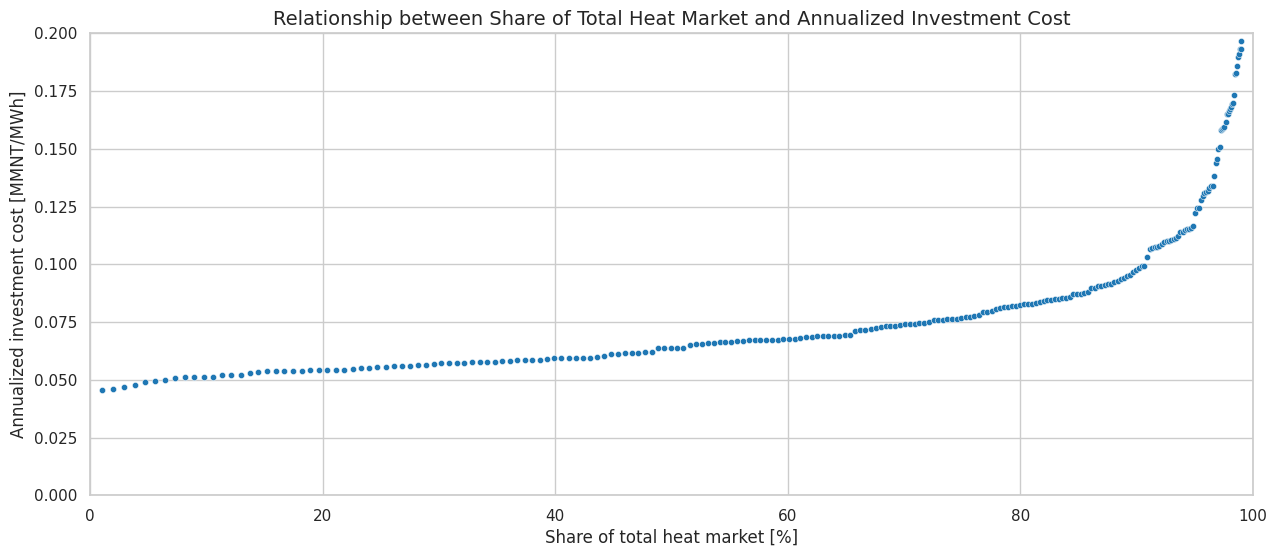

time: 631 ms (started: 2024-04-15 11:17:04 +00:00)


In [ ]:
#Plots
# Set style
sns.set_context('notebook')
sns.set_style('whitegrid')

# Set figure size
plt.figure(figsize=(15, 6))

# Plot data
ax = sns.scatterplot(data=DH_grid, x="HD_%_ACC", y="MMNT_MWh", s=20, marker="o")

# Set labels and title
plt.xlabel("Share of total heat market [%]", fontsize=12)
plt.ylabel("Annualized investment cost [MMNT/MWh]", fontsize=12)
plt.title("Relationship between Share of Total Heat Market and Annualized Investment Cost", fontsize=14)

# Set limits for visualization purposes
ax.set_ylim(0, 0.2)
ax.set_xlim(0, 100)

# Show plot
plt.show()

In [ ]:
# @title Define the share of DH of heat market
# @markdown Input the share of DH in % for the calculation { display-mode: "form" }

# @markdown ---
DHP = 80 # @param {type:"slider", min:0, max:100, step:5}

print(f"The DH potential is set to {DHP}% of the total heat market")

The DH potential is set to 80% of the total heat market
time: 885 µs (started: 2024-04-15 11:17:05 +00:00)


Text(0.5, 1.0, 'District Heating Potential')

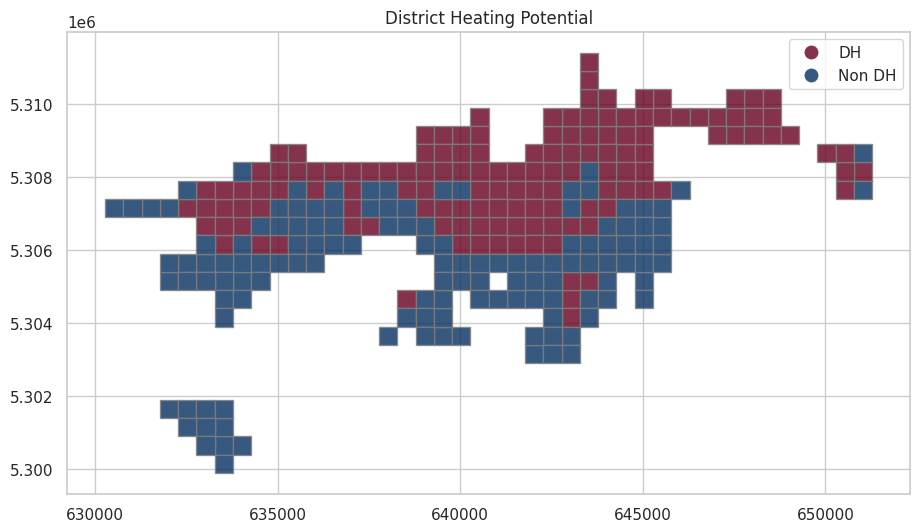

time: 706 ms (started: 2024-04-15 11:17:05 +00:00)


In [ ]:
#Selects the DH %
DH_grid['in_dhp'] = 'Non DH'
DH_grid.loc[DH_grid['HD_%_ACC'] <= DHP, ['in_dhp']] = "DH"

#Plots
fig, ax = plt.subplots(figsize= (15,6))
DH_grid.plot(ax=ax, column="in_dhp",categorical=True, edgecolor="grey",cmap='RdBu', legend=True, alpha=0.8)#, legend_kwds={"orientation": "horizontal", "pad": 0.01})
ax.set_title(f"District Heating Potential")

In [ ]:
#creates pivot and sums
pivot = pd.pivot_table(DH_grid,
                       index= ["in_dhp"],
                       values= ['heat_demand_MWh', 'MMNT_MWh'],
                       aggfunc=["sum"],
                       margins=True, margins_name="Total",
                       fill_value=0
                       ).round(0).astype(int)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 2)
display(pivot)

sum                   
       MMNT_MWh heat_demand_MWh
in_dhp                         
DH         9         3225492   
Non DH    37          806717   
Total     46         4032209

time: 48.5 ms (started: 2024-04-15 11:17:05 +00:00)


### Step 4.4. Plots interactive map (opcional)

In [ ]:
#Plots interactive map
def interactive_map_quantiles(gdf, column= 'heat_demand_MWh', num_quantiles=3, colormap= 'OrRd'):
  #Check color coding here: https://matplotlib.org/stable/users/explain/colors/colormaps.html
    # Calculate the bounds of the reprojected GeoDataFrame and centers the map
    bounds = gdf.total_bounds
    center = [(bounds[1] + bounds[3]) / 2, (bounds[0] + bounds[2]) / 2]

    # Initialize the map with Esri satellite imagery basemap
    m = folium.Map(location=center, zoom_start=9)

    # Add Esri satellite imagery as the basemap
    folium.TileLayer(
        tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
        attr='Esri',
        name='Esri Satellite',
        overlay=True,
        opacity=0.6,
    ).add_to(m)

    #Classifies the data, creates
    bins = np.linspace(gdf[column].min(), gdf[column].max(), num_quantiles + 1)

    folium.Choropleth(
        geo_data=gdf,
        data=gdf,
        columns=[gdf.index, column],
        key_on='feature.id',
        fill_color=colormap,
        fill_opacity=0.7,
        line_opacity=0.2,
        bins=bins.tolist(),
        reset=True,
        legend_name= column,
        name=column,
    ).add_to(m)

    folium.LayerControl().add_to(m)

    return m

time: 2.17 ms (started: 2024-04-15 09:22:26 +00:00)


In [ ]:
interactive_map_quantiles(gdf= DH_grid.to_crs(epsg=4326), column='heat_demand_MWh', num_quantiles=5, colormap= 'BuPu')

time: 274 ms (started: 2024-04-15 09:22:36 +00:00)


In [ ]:
interactive_map_quantiles(gdf= DH_grid.to_crs(epsg=4326), column='val_density', num_quantiles=5, colormap= 'BuPu')

time: 3.04 s (started: 2024-04-13 17:17:33 +00:00)


### Step 4.5.  Saves output

In [ ]:
#Saves the DH_grid
DH_grid.to_file('DH_grid.gpkg', driver='GPKG')

time: 965 ms (started: 2024-04-15 11:17:43 +00:00)
